In [1]:
pip install nfl_data_py

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 41.4 MB/s eta 0:00:00
  Created wheel for nfl_data_py: filename=nfl_data_py-0.3.1-py3-none-any.whl size=13187 sha256=543c5f138e116ba653f679ebfce517b5a8e485803dd72c5cd3708633d9ae2492
  Stored in directory: /root/.cache/pip/wheels/ca/2e/d2/4def312ac7c070e1c0002e91ecc6923481a86c3ebd5b2c5413
Successfully built nfl_data_py


In [2]:
import pandas as pd
import nfl_data_py as nfl
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
import seaborn as sns
import joblib

In [4]:
# Create dataframe of play by play data using nfl_data_py
seasons = list(range(2013, 2024))
pbp = nfl.import_pbp_data(seasons, downcast=True)
pbp.head()

2013 done.
2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
Downcasting floats.


,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,...,offense_players,defense_players,n_offense,n_defense,ngs_air_yards,time_to_throw,was_pressure,route,defense_man_zone_type,defense_coverage_type
0,1.0,2013_01_ARI_STL,2013090810,LA,ARI,REG,1,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,35.0,2013_01_ARI_STL,2013090810,LA,ARI,REG,1,LA,home,ARI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,57.0,2013_01_ARI_STL,2013090810,LA,ARI,REG,1,LA,home,ARI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,86.0,2013_01_ARI_STL,2013090810,LA,ARI,REG,1,LA,home,ARI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,107.0,2013_01_ARI_STL,2013090810,LA,ARI,REG,1,LA,home,ARI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
# Compute average EPA for rushing and passing for offense and defense for each game
def calculate_epa(pbp_data):
    """
    Function to calculate the EPA for rushing and passing for each team, season, and week.
    """
    # Pre-filter data for rush and pass attempts to avoid repetitive computations
    rush_attempts = pbp_data[pbp_data['rush_attempt'] == 1]
    pass_attempts = pbp_data[pbp_data['pass_attempt'] == 1]

    # Function to compute grouped mean and shifted ewma
    def compute_epa(data, group_fields):
        grouped_data = data.groupby(group_fields, as_index=False)['epa'].mean()
        grouped_data['epa_shifted'] = grouped_data['epa'].shift()
        grouped_data['ewma'] = grouped_data['epa_shifted'].ewm(min_periods=1, span=10).mean()
        return grouped_data

    # Apply the compute_epa function for each scenario
    rush_off_epa = compute_epa(rush_attempts, ['posteam', 'season', 'week'])
    rush_def_epa = compute_epa(rush_attempts, ['defteam', 'season', 'week'])
    pass_off_epa = compute_epa(pass_attempts, ['posteam', 'season', 'week'])
    pass_def_epa = compute_epa(pass_attempts, ['defteam', 'season', 'week'])

    return rush_off_epa, rush_def_epa, pass_off_epa, pass_def_epa

rush_off_epa, rush_def_epa, pass_off_epa, pass_def_epa = calculate_epa(pbp)
rush_off_epa

,posteam,season,week,epa,epa_shifted,ewma
0,ARI,2013,1,-0.138325,NaN,NaN
1,ARI,2013,2,-0.102002,-0.138325,-0.138325
2,ARI,2013,3,0.232841,-0.102002,-0.118347
3,ARI,2013,4,-0.414817,0.232841,0.022828
4,ARI,2013,5,-0.190540,-0.414817,-0.121356
...,...,...,...,...,...,...
5977,WAS,2023,13,0.118076,-0.172794,-0.085561
5978,WAS,2023,15,-0.248925,0.118076,-0.048536
5979,WAS,2023,16,0.270150,-0.248925,-0.084970
5980,WAS,2023,17,0.125432,0.270150,-0.020403


In [27]:
def dynamic_window(epa_data):
    # Use numpy to create an array of the same shape as epa_data
    values = np.zeros(epa_data.shape[0])

    # Determine the span for each row
    span = np.where(epa_data['week'] > 10, epa_data['week'], 10)

    # Vectorized operation to calculate exponentially weighted mean
    for i in range(len(values)):
        values[i] = epa_data['epa_shifted'].iloc[:i+1].ewm(min_periods=1, span=span[i]).mean().iloc[-1]

    return pd.Series(values, index=epa_data.index)


In [28]:
# Compute dynamically shifted EPA's
rush_off_epa['ewma_dynamic'] = rush_off_epa.groupby('posteam').apply(dynamic_window).values
pass_off_epa['ewma_dynamic'] = pass_off_epa.groupby('posteam').apply(dynamic_window).values
rush_def_epa['ewma_dynamic'] = rush_def_epa.groupby('defteam').apply(dynamic_window).values
pass_def_epa['ewma_dynamic'] = pass_def_epa.groupby('defteam').apply(dynamic_window).values
rush_off_epa

,posteam,season,week,epa,epa_shifted,ewma,ewma_dynamic
0,ARI,2013,1,-0.138325,NaN,NaN,NaN
1,ARI,2013,2,-0.102002,-0.138325,-0.138325,-0.138325
2,ARI,2013,3,0.232841,-0.102002,-0.118347,-0.118347
3,ARI,2013,4,-0.414817,0.232841,0.022828,0.022828
4,ARI,2013,5,-0.190540,-0.414817,-0.121356,-0.121356
...,...,...,...,...,...,...,...
5977,WAS,2023,13,0.118076,-0.172794,-0.085561,-0.076909
5978,WAS,2023,15,-0.248925,0.118076,-0.048536,-0.048704
5979,WAS,2023,16,0.270150,-0.248925,-0.084970,-0.072028
5980,WAS,2023,17,0.125432,0.270150,-0.020403,-0.032612


In [29]:
# Combine EPA into offense and defense
off_epa = rush_off_epa.merge(pass_off_epa, on=['posteam', 'season', 'week'], suffixes=['_rush', '_pass']).rename(columns={'posteam': 'team'})
def_epa = rush_def_epa.merge(pass_def_epa, on=['defteam', 'season', 'week'], suffixes=['_rush', '_pass']).rename(columns={'defteam': 'team'})
off_epa

,team,season,week,epa_rush,epa_shifted_rush,ewma_rush,ewma_dynamic_rush,epa_pass,epa_shifted_pass,ewma_pass,ewma_dynamic_pass
0,ARI,2013,1,-0.138325,NaN,NaN,NaN,0.165290,NaN,NaN,NaN
1,ARI,2013,2,-0.102002,-0.138325,-0.138325,-0.138325,-0.246375,0.165290,0.165290,0.165290
2,ARI,2013,3,0.232841,-0.102002,-0.118347,-0.118347,-0.434779,-0.246375,-0.061126,-0.061126
3,ARI,2013,4,-0.414817,0.232841,0.022828,0.022828,-0.121494,-0.434779,-0.211332,-0.211332
4,ARI,2013,5,-0.190540,-0.414817,-0.121356,-0.121356,-0.090037,-0.121494,-0.181734,-0.181734
...,...,...,...,...,...,...,...,...,...,...,...
5977,WAS,2023,13,0.118076,-0.172794,-0.085561,-0.076909,-0.482269,-0.257268,-0.101118,-0.101474
5978,WAS,2023,15,-0.248925,0.118076,-0.048536,-0.048704,-0.085142,-0.482269,-0.170418,-0.149791
5979,WAS,2023,16,0.270150,-0.248925,-0.084970,-0.072028,-0.459513,-0.085142,-0.154914,-0.140048
5980,WAS,2023,17,0.125432,0.270150,-0.020403,-0.032612,-0.332157,-0.459513,-0.210295,-0.174228


In [30]:
# Combine offense and defense into one table
epa = off_epa.merge(def_epa, on=['team', 'season', 'week'], suffixes=['_off', '_def'])
epa

,team,season,week,epa_rush_off,epa_shifted_rush_off,ewma_rush_off,ewma_dynamic_rush_off,epa_pass_off,epa_shifted_pass_off,ewma_pass_off,ewma_dynamic_pass_off,epa_rush_def,epa_shifted_rush_def,ewma_rush_def,ewma_dynamic_rush_def,epa_pass_def,epa_shifted_pass_def,ewma_pass_def,ewma_dynamic_pass_def
0,ARI,2013,1,-0.138325,NaN,NaN,NaN,0.165290,NaN,NaN,NaN,-0.220083,NaN,NaN,NaN,0.083047,NaN,NaN,NaN
1,ARI,2013,2,-0.102002,-0.138325,-0.138325,-0.138325,-0.246375,0.165290,0.165290,0.165290,-0.481724,-0.220083,-0.220083,-0.220083,0.194984,0.083047,0.083047,0.083047
2,ARI,2013,3,0.232841,-0.102002,-0.118347,-0.118347,-0.434779,-0.246375,-0.061126,-0.061126,-0.110586,-0.481724,-0.363985,-0.363985,0.219540,0.194984,0.144612,0.144612
3,ARI,2013,4,-0.414817,0.232841,0.022828,0.022828,-0.121494,-0.434779,-0.211332,-0.211332,-0.218880,-0.110586,-0.262121,-0.262121,-0.226535,0.219540,0.174733,0.174733
4,ARI,2013,5,-0.190540,-0.414817,-0.121356,-0.121356,-0.090037,-0.121494,-0.181734,-0.181734,-0.041743,-0.218880,-0.247875,-0.247875,-0.434112,-0.226535,0.042533,0.042533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5977,WAS,2023,13,0.118076,-0.172794,-0.085561,-0.076909,-0.482269,-0.257268,-0.101118,-0.101474,0.162601,0.227489,-0.057011,-0.063280,0.744556,0.583189,0.193230,0.163497
5978,WAS,2023,15,-0.248925,0.118076,-0.048536,-0.048704,-0.085142,-0.482269,-0.170418,-0.149791,-0.120080,0.162601,-0.017081,-0.037171,0.090042,0.744556,0.293471,0.222337
5979,WAS,2023,16,0.270150,-0.248925,-0.084970,-0.072028,-0.459513,-0.085142,-0.154914,-0.140048,-0.122933,-0.120080,-0.035808,-0.049127,-0.325978,0.090042,0.256484,0.197540
5980,WAS,2023,17,0.125432,0.270150,-0.020403,-0.032612,-0.332157,-0.459513,-0.210295,-0.174228,0.028499,-0.122933,-0.051649,-0.058595,0.370420,-0.325978,0.150582,0.132535


In [31]:
# Drop first week of data
epa = epa.loc[~((epa['season'] == 2013) & (epa['week'] == 1))]
epa = epa.reset_index(drop=True)
epa

,team,season,week,epa_rush_off,epa_shifted_rush_off,ewma_rush_off,ewma_dynamic_rush_off,epa_pass_off,epa_shifted_pass_off,ewma_pass_off,ewma_dynamic_pass_off,epa_rush_def,epa_shifted_rush_def,ewma_rush_def,ewma_dynamic_rush_def,epa_pass_def,epa_shifted_pass_def,ewma_pass_def,ewma_dynamic_pass_def
0,ARI,2013,2,-0.102002,-0.138325,-0.138325,-0.138325,-0.246375,0.165290,0.165290,0.165290,-0.481724,-0.220083,-0.220083,-0.220083,0.194984,0.083047,0.083047,0.083047
1,ARI,2013,3,0.232841,-0.102002,-0.118347,-0.118347,-0.434779,-0.246375,-0.061126,-0.061126,-0.110586,-0.481724,-0.363985,-0.363985,0.219540,0.194984,0.144612,0.144612
2,ARI,2013,4,-0.414817,0.232841,0.022828,0.022828,-0.121494,-0.434779,-0.211332,-0.211332,-0.218880,-0.110586,-0.262121,-0.262121,-0.226535,0.219540,0.174733,0.174733
3,ARI,2013,5,-0.190540,-0.414817,-0.121356,-0.121356,-0.090037,-0.121494,-0.181734,-0.181734,-0.041743,-0.218880,-0.247875,-0.247875,-0.434112,-0.226535,0.042533,0.042533
4,ARI,2013,6,0.116267,-0.190540,-0.141217,-0.141217,-0.188241,-0.090037,-0.155411,-0.155411,0.020516,-0.041743,-0.188700,-0.188700,-0.037609,-0.434112,-0.094299,-0.094299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5945,WAS,2023,13,0.118076,-0.172794,-0.085561,-0.076909,-0.482269,-0.257268,-0.101118,-0.101474,0.162601,0.227489,-0.057011,-0.063280,0.744556,0.583189,0.193230,0.163497
5946,WAS,2023,15,-0.248925,0.118076,-0.048536,-0.048704,-0.085142,-0.482269,-0.170418,-0.149791,-0.120080,0.162601,-0.017081,-0.037171,0.090042,0.744556,0.293471,0.222337
5947,WAS,2023,16,0.270150,-0.248925,-0.084970,-0.072028,-0.459513,-0.085142,-0.154914,-0.140048,-0.122933,-0.120080,-0.035808,-0.049127,-0.325978,0.090042,0.256484,0.197540
5948,WAS,2023,17,0.125432,0.270150,-0.020403,-0.032612,-0.332157,-0.459513,-0.210295,-0.174228,0.028499,-0.122933,-0.051649,-0.058595,0.370420,-0.325978,0.150582,0.132535


In [32]:
# Create table of game results
games = pbp[['season', 'week', 'home_team', 'away_team', 'home_score', 'away_score']].drop_duplicates().reset_index(drop=True)
games['pnt_diff'] = abs(games['home_score'] - games['away_score'])
games['total'] = games['home_score'] + games['away_score']
games

,season,week,home_team,away_team,home_score,away_score,pnt_diff,total
0,2013,1,LA,ARI,27,24,3,51
1,2013,1,NO,ATL,23,17,6,40
2,2013,1,DEN,BAL,49,27,22,76
3,2013,1,CHI,CIN,24,21,3,45
4,2013,1,SF,GB,34,28,6,62
...,...,...,...,...,...,...,...,...
2986,2023,20,BAL,HOU,34,10,24,44
2987,2023,20,BUF,KC,24,27,3,51
2988,2023,20,DET,TB,31,23,8,54
2989,2023,21,SF,DET,34,31,3,65


In [33]:
# Create binary label for win/loss
games['home_team_win'] = np.where(games['home_score'] > games['away_score'], 1, 0)
games.head()

,season,week,home_team,away_team,home_score,away_score,pnt_diff,total,home_team_win
0,2013,1,LA,ARI,27,24,3,51,1
1,2013,1,NO,ATL,23,17,6,40,1
2,2013,1,DEN,BAL,49,27,22,76,1
3,2013,1,CHI,CIN,24,21,3,45,1
4,2013,1,SF,GB,34,28,6,62,1


In [39]:
merged_df = games.merge(epa, left_on=['home_team', 'season', 'week'], right_on=['team', 'season', 'week'])
merged_df = merged_df.merge(epa, left_on=['away_team', 'season', 'week'], right_on=['team', 'season', 'week'], suffixes=('_home', '_away'))
final = merged_df.drop(columns=['team_home', 'epa_rush_off_home', 'epa_pass_off_home', 'epa_rush_def_home', 'epa_pass_def_home', 'team_away', 'epa_rush_off_away', 'epa_pass_off_away',
        'epa_rush_def_away', 'epa_pass_def_away'], axis=1)
final

,season,week,home_team,away_team,home_score,away_score,pnt_diff,total,home_team_win,epa_shifted_rush_off_home,...,ewma_dynamic_rush_off_away,epa_shifted_pass_off_away,ewma_pass_off_away,ewma_dynamic_pass_off_away,epa_shifted_rush_def_away,ewma_rush_def_away,ewma_dynamic_rush_def_away,epa_shifted_pass_def_away,ewma_pass_def_away,ewma_dynamic_pass_def_away
0,2013,2,BUF,CAR,24,23,1,47,1,-0.159322,...,0.009307,0.160565,0.110294,0.155020,-0.319403,-0.037846,-0.115084,0.324692,0.004189,0.321404
1,2013,2,BAL,CLE,14,6,8,20,1,-0.306154,...,-0.039174,-0.186911,-0.006080,-0.118111,-0.381248,-0.082467,-0.252177,0.182691,0.069647,-0.069545
2,2013,2,KC,DAL,17,16,1,33,1,-0.003425,...,-0.206065,-0.136598,-0.162579,-0.234962,-0.978725,-0.259664,-0.602063,0.176887,0.002640,0.368884
3,2013,2,NYG,DEN,23,41,18,64,0,-0.978725,...,0.098098,0.549780,0.228923,0.278687,-0.306154,-0.158575,-0.150022,0.051451,0.138074,0.541303
4,2013,2,ARI,DET,25,21,4,46,1,-0.138325,...,-0.129787,0.127161,-0.010807,0.074014,-0.263905,-0.162151,-0.163376,-0.010962,0.036575,0.113630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2970,2023,20,BAL,HOU,34,10,24,44,1,-0.455446,...,-0.151727,0.603547,0.130655,0.057325,-0.187198,-0.168308,-0.134256,-0.355186,-0.112088,-0.064602
2971,2023,20,BUF,KC,24,27,3,51,0,0.261939,...,-0.049037,0.196790,-0.011363,0.041553,0.062528,-0.035128,-0.021073,-0.340118,-0.207211,-0.164232
2972,2023,20,DET,TB,31,23,8,54,1,-0.044500,...,-0.170045,0.288088,0.113669,0.091341,-0.370516,-0.148563,-0.133129,-0.081463,-0.066635,-0.007964
2973,2023,21,SF,DET,34,31,3,65,1,0.041095,...,-0.040821,0.180241,0.207873,0.174092,0.016074,-0.123818,-0.105764,0.083998,0.120926,0.083886


#Predict 2022 Outcomes


In [41]:
# Create features for Logistic Regression
features = [column for column in final.columns if 'dynamic' in column]

final = final.dropna()

X = final.loc[final['season'] != 2023, features].values
y = final.loc[final['season'] != 2023, 'home_team_win'].values

clf = LogisticRegression()
clf.fit(X,y)

LogisticRegression()

In [43]:
# Accuracy of Model using cross validation
accuracy_scores = cross_val_score(clf, X, y, cv=10)
log_losses = cross_val_score(clf, X, y, cv=10, scoring='neg_log_loss')

print('Model Accuracy:', np.mean(accuracy_scores))

Model Accuracy: 0.6380600302905135


In [44]:
# Compute cross entropy loss
print('Neg log loss:', np.mean(log_losses))

Neg log loss: -0.6398025276787827


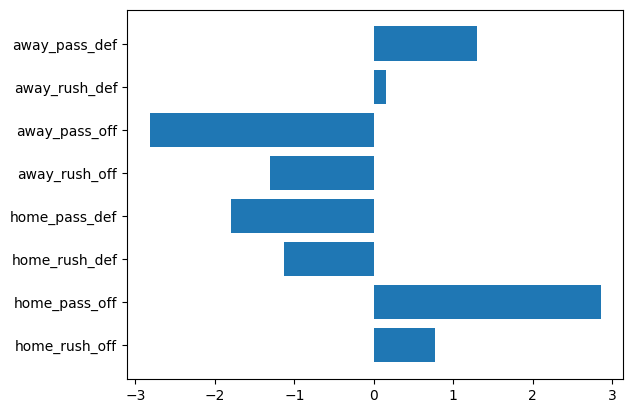

In [45]:
importance = clf.coef_
plt.barh(np.arange(len(features)), importance[0])
plt.yticks(np.arange(len(features)), ['home_rush_off', 'home_pass_off', 'home_rush_def',
                                      'home_pass_def', 'away_rush_off', 'away_pass_off',
                                      'away_rush_def', 'away_pass_def'])
plt.show()


In [46]:
# Compute Results for entire 2022 Season and display top 10 predictions
df_2022 = final.loc[(final['season'] == 2022)].assign(
    predicted_winner = lambda x: clf.predict(x[features].values),
    home_team_win_probability = lambda x: clf.predict_proba(x[features].values)[:, 1]
)\
[['home_team', 'away_team', 'week', 'predicted_winner', 'home_team_win_probability', 'home_team_win']]

df_2022['actual_winner'] = df_2022.apply(lambda x: x.home_team if x.home_team_win else x.away_team, axis=1)
df_2022['predicted_winner'] = df_2022.apply(lambda x: x.home_team if x.predicted_winner == 1 else x.away_team, axis=1)
df_2022['win_probability'] = df_2022.apply(lambda x: x.home_team_win_probability if x.predicted_winner == x.home_team else 1 - x.home_team_win_probability, axis=1)
df_2022['correct_prediction'] = (df_2022['predicted_winner'] == df_2022['actual_winner']).astype(int)

df_2022 = df_2022.drop(columns=['home_team_win_probability', 'home_team_win'])

df_2022.sort_values(by='win_probability', ascending=False).reset_index(drop=True).head(10)

,home_team,away_team,week,predicted_winner,actual_winner,win_probability,correct_prediction
0,TEN,NYG,1,TEN,NYG,0.899253,0
1,DAL,HOU,14,DAL,DAL,0.872274,1
2,GB,NYG,5,GB,NYG,0.821318,0
3,BUF,PIT,5,BUF,BUF,0.818557,1
4,MIA,HOU,12,MIA,MIA,0.811800,1
5,NYG,DAL,3,DAL,DAL,0.804883,1
6,DAL,IND,13,DAL,DAL,0.802497,1
7,KC,DEN,17,KC,KC,0.796484,1
8,PHI,WAS,10,PHI,WAS,0.793835,0
9,SF,ARI,18,SF,SF,0.792685,1


In [47]:
# 2023 Accuracy
df_2022['correct_prediction'].value_counts()[1]/len(df_2022['correct_prediction'])

0.676056338028169

Text(0, 0.5, 'Accuracy of Prediction')

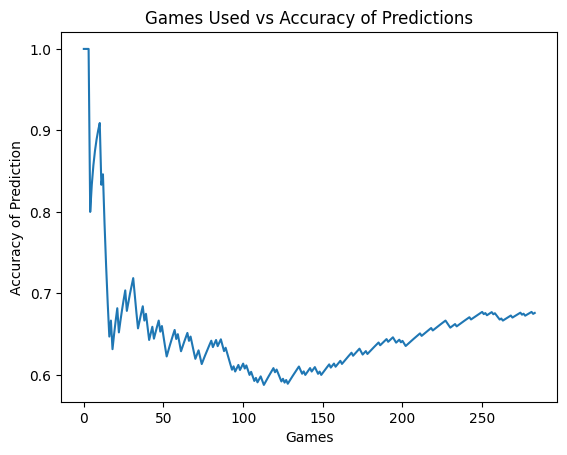

In [48]:
# Accuracy of model throughout 2022 Season
acc = []
for i in range(1, len(df_2022['correct_prediction']) + 1):
    val = df_2022['correct_prediction'].iloc[:i].value_counts()[1]/(i)
    acc.append(val)

plt.plot(range(len(range(1, len(df_2022['correct_prediction']) + 1))), acc)
plt.title('Games Used vs Accuracy of Predictions')
plt.xlabel('Games')
plt.ylabel('Accuracy of Prediction')

Text(0, 0.5, 'Accuracy')

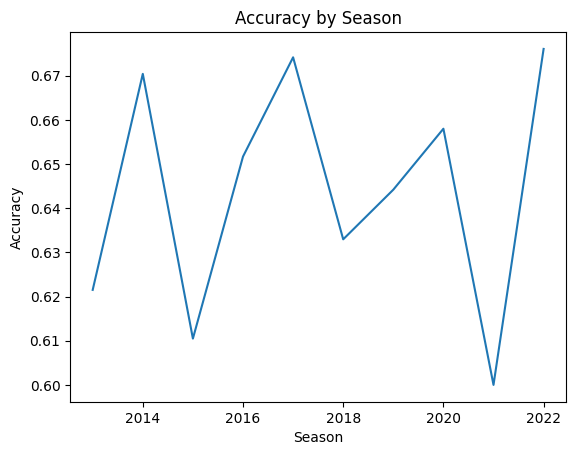

In [51]:
# Accuracy of model by season
accs = []
for i in range(2013, 2023):
    df = final.loc[(final['season'] == i)].assign(
        predicted_winner = lambda x: clf.predict(x[features].values),
        home_team_win_probability = lambda x: clf.predict_proba(x[features].values)[:, 1]
    )\
    [['home_team', 'away_team', 'week', 'predicted_winner', 'home_team_win_probability', 'home_team_win']]

    df['actual_winner'] = df.apply(lambda x: x.home_team if x.home_team_win else x.away_team, axis=1)
    df['predicted_winner'] = df.apply(lambda x: x.home_team if x.predicted_winner == 1 else x.away_team, axis=1)
    df['correct_prediction'] = (df['predicted_winner'] == df['actual_winner']).astype(int)

    accs.append(df['correct_prediction'].value_counts()[1]/len(df['correct_prediction']))


plt.plot(range(2013, 2023), accs)
plt.title('Accuracy by Season')
plt.xlabel('Season')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Confidence')

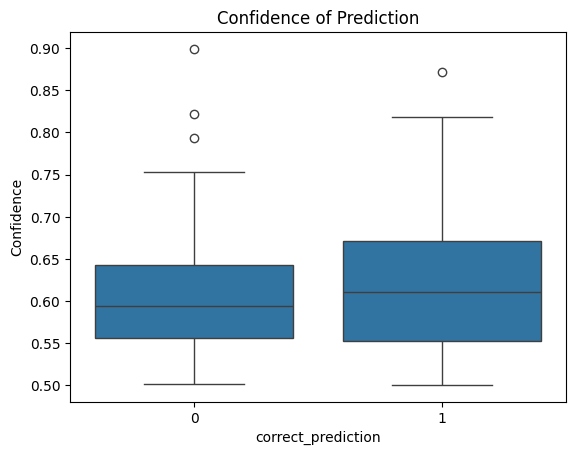

In [52]:
# Comparing correct and incorrect predictions by initial confidence of prediction
sns.boxplot(y = 'win_probability', x  = 'correct_prediction', data = df_2022)
plt.title('Confidence of Prediction')
plt.ylabel('Confidence')

Text(0, 0.5, 'Confidence')

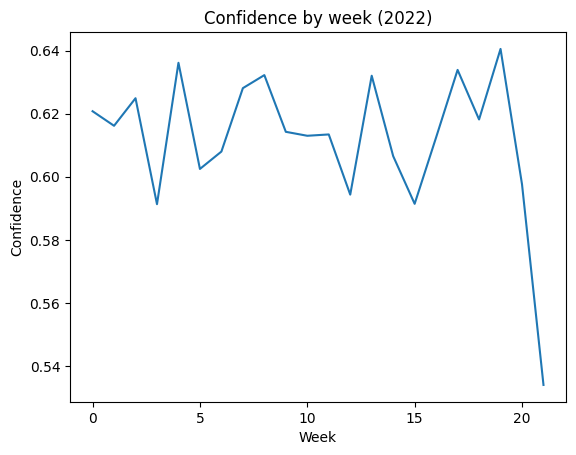

In [53]:
# Chance of winning by week
plt.plot(range(df_2022['week'].nunique()), df_2022.groupby('week')['win_probability'].mean())
plt.title('Confidence by week (2022)')
plt.xlabel('Week')
plt.ylabel('Confidence')

# Seasonal Accuracy by Years of Data

<ipython-input-55-b8bf4227d913>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual_winner'] = df.apply(lambda x: x.home_team if x.home_team_win else x.away_team, axis=1)
<ipython-input-55-b8bf4227d913>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predicted_winner'] = df.apply(lambda x: x.home_team if x.predicted_winner == 1 else x.away_team, axis=1)
<ipython-input-55-b8bf4227d913>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

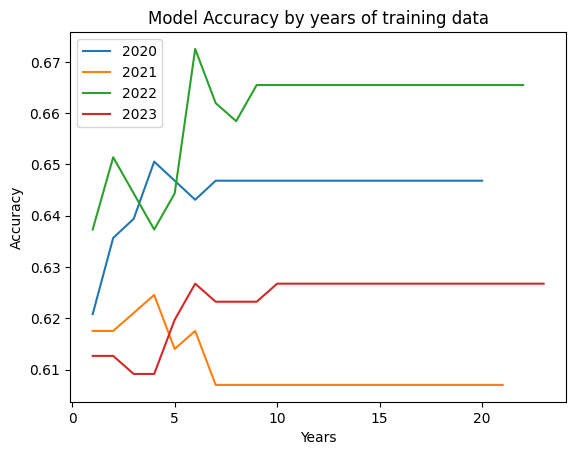

In [55]:
for j in range(2020, 2024):
    accs = []
    for i in range(0, j - 2000):
        years = [*range((j-1)-i, j)]

        X = final.loc[final['season'].isin(years), features].values
        y = final.loc[final['season'].isin(years), 'home_team_win'].values
        clf = LogisticRegression()
        clf.fit(X,y)

        df = final.loc[(final['season'] == j)].assign(
        predicted_winner = lambda x: clf.predict(x[features].values),
        )\
        [['home_team', 'away_team', 'week', 'predicted_winner', 'home_team_win']]

        df['actual_winner'] = df.apply(lambda x: x.home_team if x.home_team_win else x.away_team, axis=1)
        df['predicted_winner'] = df.apply(lambda x: x.home_team if x.predicted_winner == 1 else x.away_team, axis=1)
        df['correct_prediction'] = (df['predicted_winner'] == df['actual_winner']).astype(int)

        accs.append(df['correct_prediction'].value_counts()[1]/len(df['correct_prediction']))


    plt.plot(range(1, j - 1999), accs)
    plt.title('Model Accuracy by years of training data')
    plt.xlabel('Years')
    plt.ylabel('Accuracy')
    plt.legend([*range(2020, 2024)])

Text(0, 0.5, 'Accuracy')

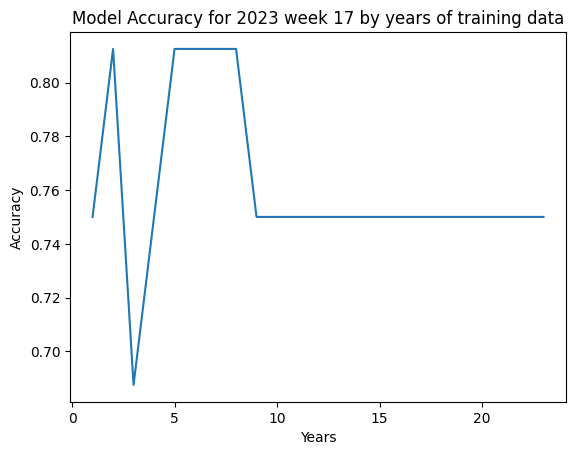

In [56]:
# 2023 week 17 predictions by years of data
wk17_X = final.loc[(final['season'] == 2023) & (final['week'] < 17), features].values
wk17_y = final.loc[(final['season'] == 2023) & (final['week'] < 17), 'home_team_win'].values

accs = []
for i in range(1, 24):
    years = [*range(2023-i, 2023)]

    X = final.loc[final['season'].isin(years), features].values
    X = np.concatenate((X, wk17_X))
    y = final.loc[final['season'].isin(years), 'home_team_win'].values
    y = np.concatenate((y, wk17_y))
    clf = LogisticRegression()
    clf.fit(X,y)

    df = final.loc[(final['season'] == 2023) & (final['week'] == 17)].assign(
    predicted_winner = lambda x: clf.predict(x[features].values),
    )\
    [['home_team', 'away_team', 'week', 'predicted_winner', 'home_team_win']]

    df['actual_winner'] = df.apply(lambda x: x.home_team if x.home_team_win else x.away_team, axis=1)
    df['predicted_winner'] = df.apply(lambda x: x.home_team if x.predicted_winner == 1 else x.away_team, axis=1)
    df['correct_prediction'] = (df['predicted_winner'] == df['actual_winner']).astype(int)

    accs.append(df['correct_prediction'].value_counts()[1]/len(df['correct_prediction']))


plt.plot(range(1, 24), accs)
plt.title('Model Accuracy for 2023 week 17 by years of training data')
plt.xlabel('Years')
plt.ylabel('Accuracy')


Text(0, 0.5, 'Accuracy')

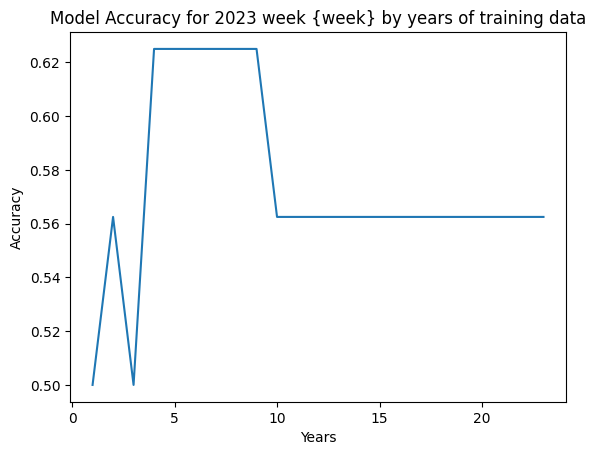

In [57]:
week = 16
wk17_X = final.loc[(final['season'] == 2023) & (final['week'] < week), features].values
wk17_y = final.loc[(final['season'] == 2023) & (final['week'] < week), 'home_team_win'].values

accs = []
for i in range(1, 24):
    years = [*range(2023-i, 2023)]

    X = final.loc[final['season'].isin(years), features].values
    X = np.concatenate((X, wk17_X))
    y = final.loc[final['season'].isin(years), 'home_team_win'].values
    y = np.concatenate((y, wk17_y))
    clf = LogisticRegression()
    clf.fit(X,y)

    df = final.loc[(final['season'] == 2023) & (final['week'] == week)].assign(
    predicted_winner = lambda x: clf.predict(x[features].values),
    )\
    [['home_team', 'away_team', 'week', 'predicted_winner', 'home_team_win']]

    df['actual_winner'] = df.apply(lambda x: x.home_team if x.home_team_win else x.away_team, axis=1)
    df['predicted_winner'] = df.apply(lambda x: x.home_team if x.predicted_winner == 1 else x.away_team, axis=1)
    df['correct_prediction'] = (df['predicted_winner'] == df['actual_winner']).astype(int)

    accs.append(df['correct_prediction'].value_counts()[1]/len(df['correct_prediction']))


plt.plot(range(1, 24), accs)
plt.title('Model Accuracy for 2023 week {week} by years of training data')
plt.xlabel('Years')
plt.ylabel('Accuracy')

# Week Prediction

In [58]:
week = 22
features = [column for column in final.columns if 'dynamic' in column]
# features.extend(['cpoe_shifted_home', 'cpoe_shifted_away'])

# Remove week 18
train_data = final.loc[~final['week'].isin([18, week])]


X = train_data.loc[(train_data['season'] >= 2023 - 10), features].values
y = train_data.loc[(train_data['season'] >= 2023 - 10), 'home_team_win'].values

clf2 = LogisticRegression(max_iter=100)
clf2.fit(X,y)

LogisticRegression()

In [61]:
prev_stats = epa.loc[(epa['week'] == (week - 1)) & (epa['season'] == 2023)]
prev_stats.rename(columns={'week': 'prev_week'}, inplace=True)
prev_stats

<ipython-input-61-6c6bd864c11e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prev_stats.rename(columns={'week': 'prev_week'}, inplace=True)


,team,season,prev_week,epa_rush_off,epa_shifted_rush_off,ewma_rush_off,ewma_dynamic_rush_off,epa_pass_off,epa_shifted_pass_off,ewma_pass_off,ewma_dynamic_pass_off,epa_rush_def,epa_shifted_rush_def,ewma_rush_def,ewma_dynamic_rush_def,epa_pass_def,epa_shifted_pass_def,ewma_pass_def,ewma_dynamic_pass_def
551,BAL,2023,21,0.129910,0.258387,-0.013661,0.001516,-0.292842,0.155950,0.211540,0.134367,-0.277561,-0.419519,-0.120584,-0.094933,0.189838,-0.130740,-0.160047,-0.143965
2027,DET,2023,21,0.078229,0.048534,-0.029037,-0.040821,0.162754,0.180241,0.207873,0.174092,0.218215,0.016074,-0.123818,-0.105764,0.200745,0.083998,0.120926,0.083886
2975,KC,2023,21,-0.277561,0.134640,-0.030300,-0.030982,0.189838,0.317385,0.048410,0.070902,0.129910,0.138143,-0.003624,-0.005860,-0.292842,0.148241,-0.142584,-0.132756
5397,SF,2023,21,0.218215,0.041095,0.067811,0.033895,0.200745,0.179048,0.244385,0.257588,0.078229,-0.067005,-0.036706,-0.050987,0.162754,-0.003857,-0.039510,-0.076876




```
# This is formatted as code
```

# 2023 Super Bowl Prediction

In [63]:
# 2023 Schedule
sched = nfl.import_schedules([2023])
sched[['away_team', 'home_team']] = sched[['away_team', 'home_team']].astype(str)

In [64]:
wk = sched.loc[sched['week'] == week][['season', 'week', 'home_team', 'away_team', 'result']]
wk

,season,week,home_team,away_team,result
6705,2023,22,KC,SF,NaN


In [65]:
home_pred = wk.merge(prev_stats.rename(columns={'team': 'home_team'}), on=['home_team'])
away_pred = wk.merge(prev_stats.rename(columns={'team': 'away_team'}), on=['away_team'])
home_pred

,season_x,week,home_team,away_team,result,season_y,prev_week,epa_rush_off,epa_shifted_rush_off,ewma_rush_off,...,ewma_pass_off,ewma_dynamic_pass_off,epa_rush_def,epa_shifted_rush_def,ewma_rush_def,ewma_dynamic_rush_def,epa_pass_def,epa_shifted_pass_def,ewma_pass_def,ewma_dynamic_pass_def
0,2023,22,KC,SF,NaN,2023,21,-0.277561,0.13464,-0.0303,...,0.04841,0.070902,0.12991,0.138143,-0.003624,-0.00586,-0.292842,0.148241,-0.142584,-0.132756


In [66]:
final_pred = home_pred.merge(away_pred, on=['season_x', 'week', 'home_team', 'away_team'], suffixes=('_home', '_away'))
final_pred

,season_x,week,home_team,away_team,result_home,season_y_home,prev_week_home,epa_rush_off_home,epa_shifted_rush_off_home,ewma_rush_off_home,...,ewma_pass_off_away,ewma_dynamic_pass_off_away,epa_rush_def_away,epa_shifted_rush_def_away,ewma_rush_def_away,ewma_dynamic_rush_def_away,epa_pass_def_away,epa_shifted_pass_def_away,ewma_pass_def_away,ewma_dynamic_pass_def_away
0,2023,22,KC,SF,NaN,2023,21,-0.277561,0.13464,-0.0303,...,0.244385,0.257588,0.078229,-0.067005,-0.036706,-0.050987,0.162754,-0.003857,-0.03951,-0.076876


In [67]:
# Compute Results for the week
df_week = final_pred.assign(
    predicted_winner = lambda x: clf2.predict(x[features].values),
    home_team_win_probability = lambda x: clf2.predict_proba(x[features].values)[:, 1]
)\
[['week','home_team', 'away_team', 'predicted_winner', 'home_team_win_probability']]

df_week['predicted_winner'] = df_week.apply(lambda x: x.home_team if x.predicted_winner == 1 else x.away_team, axis=1)
df_week['win_probability'] = df_week.apply(lambda x: x.home_team_win_probability if x.predicted_winner == x.home_team else 1 - x.home_team_win_probability, axis=1)

df_week = df_week.drop(columns=['home_team_win_probability'])

df_week.sort_values(by='win_probability', ascending=False).reset_index(drop=True)

,week,home_team,away_team,predicted_winner,win_probability
0,22,KC,SF,SF,0.564307


# 2023 Models for Web App

In [ ]:
# def remove_week(df):
#     condition = (df['week'] == 17) & (df['season'] < 2021) | (df['week'] == 18) & (df['season'] >= 2021)
#     return df[~condition]


In [ ]:
# for week in range(1, 19):
#   features = [column for column in final.columns if 'dynamic' in column]

#   # Remove final week of seasons and subset to past 10 years
#   train_data = remove_week(final.loc[final['season'] >= 2023 - 10])

#   X = train_data.loc[(train_data['season'] < 2023) | ((train_data['season'] == 2023) & (train_data['week'] < week)), features].values
#   y = train_data.loc[(train_data['season'] < 2023) | ((train_data['season'] == 2023) & (train_data['week'] < week)), 'home_team_win'].values

#   model = LogisticRegression(max_iter=100)
#   model.fit(X,y)

#   # Save model
#   joblib.dump(model, f'model_week{week}.pkl')